# Predicting Mortgage Prepayment using Deep Neural Network 





In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
#Read the csv file

data = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/ANLY535/ANLY535 Final Project/Main_Data.xlsx')
data.drop(['Date'],axis = 1 , inplace = True)
data.head()

,MBA Refi Index,2yr Yield,10yr Yield,10yr-2yr Spread,Jobless Claims('000),Non Farm Payroll,National HPI,PPI,Privately Owned Housing Unites,PPI Wood Pulp,Perosnal Savings Rate,PCE,Personal Consumption Expenditure,Moodys BBB Yield,Moodys AAA Yield,House Supply,Monetary Base,M2 Supply,M1 Supply,Labor Force Partcipation,Industrial Production,Currency in Circulation,WTI,CPI,CPI Total,CPI Less Food and Energy
0,102.7,8.622,8.628,0.006,346,109644,76.790,121.2,1289,158.7,8.3,64.323,3754.9,10.21,9.37,7.8,292400,3190.1,801.5,66.7,62.7645,256.690,20.39,128.6,0.546875,133.5
1,102.7,8.622,8.628,0.006,346,109644,76.790,121.2,1289,158.7,8.3,64.323,3754.9,10.21,9.37,7.8,292400,3190.1,801.5,66.7,62.7645,256.690,20.39,128.6,0.546875,133.5
2,102.7,8.622,8.628,0.006,346,109686,77.039,120.4,1248,155.4,8.8,64.515,3770.0,10.30,9.46,8.3,297400,3201.6,806.1,66.6,62.6499,259.829,18.43,128.9,0.155400,134.0
3,102.7,8.604,8.640,0.036,346,109686,77.039,120.4,1248,155.4,8.8,64.515,3770.0,10.30,9.46,8.3,297400,3201.6,806.1,66.6,62.6499,259.829,18.43,128.9,0.155400,134.0
4,102.7,8.596,8.626,0.030,346,109686,77.039,120.4,1248,155.4,8.8,64.515,3770.0,10.30,9.46,8.3,297400,3201.6,806.1,66.6,62.6499,259.829,18.43,128.9,0.155400,134.0


In [ ]:
X = data.drop('MBA Refi Index',axis =1).values
y = data['MBA Refi Index'].values
#splitting Train and Test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(11301, 25) (115, 25) (11301,) (115,)


## Exploratory Data Analysis

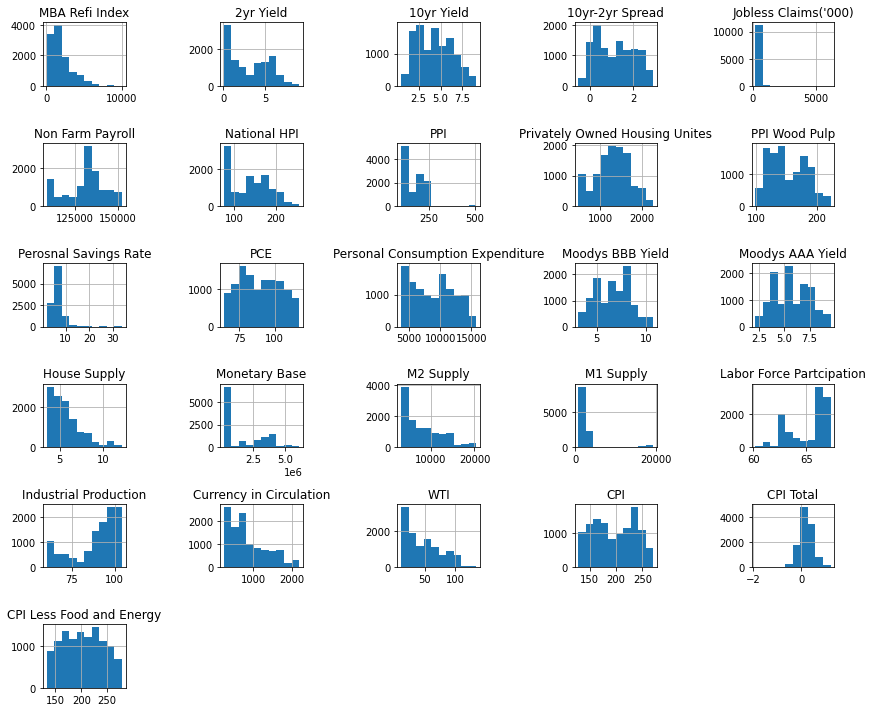

In [ ]:
data.hist(figsize = (12,10))
plt.tight_layout()
plt.show()

## Scaling

In [ ]:
#standardization scaler - fit&transform on train, fit only on test
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))

## Defining Callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Define a checkpoint to save the data
checkpoint_name = 'Models/Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
early_stop = EarlyStopping(monitor='val_mean_absolute_error', patience=10)
callbacks_list = [checkpoint, early_stop]

# Hyper Parameter Tuning

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt  

     |████████████████████████████████| 96 kB 4.4 MB/s 


In [ ]:
def MAPE(pred,actual):
  actual, pred = np.array(actual), np.array(pred)
  return np.mean(np.abs((actual-pred)/actual))*100

def model_builder(hp):
  model = Sequential()
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
# The Input Layer :
  model.add(Dense(units=hp_units, kernel_initializer='normal', activation='relu'))

# The Hidden Layers :
  model.add(Dense(256, kernel_initializer='normal',activation='relu'))
  model.add(Dense(256, kernel_initializer='normal',activation='relu'))
  model.add(Dense(256, kernel_initializer='normal',activation='relu'))
  model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
  model.add(Dense(1, kernel_initializer='normal',activation='linear'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer = Adam(learning_rate=hp_learning_rate), loss='MAPE', metrics=['mean_absolute_error','MAPE'])
  return model

tuner = kt.Hyperband(model_builder,
                     objective='MAPE',
                     max_epochs=10,
                     factor=3,
                     directory='/content/gdrive/My Drive/Colab Notebooks/ANLY535/ANLY535 Final Project/hp',
                     project_name='hp_tuning')
  
  

INFO:tensorflow:Reloading Oracle from existing project /content/gdrive/My Drive/Colab Notebooks/ANLY535/ANLY535 Final Project/hp/hp_tuning/oracle.json


In [ ]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='mean_absolute_error', patience=10)])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 42 Complete [00h 00m 12s]
MAPE: 13.06328010559082

Best MAPE So Far: 12.095330238342285
Total elapsed time: 00h 34m 26s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 448 and the optimal learning rate for the optimizer
is 0.001.



## Train Model with Searched Hyperparameters

In [ ]:
model = tuner.hypermodel.build(best_hps)


history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks = callbacks_list)

Epoch 1/500
283/283 [==============================] - 2s 4ms/step - loss: 37.7936 - mean_absolute_error: 821.2909 - MAPE: 37.7936 - val_loss: 23.8916 - val_mean_absolute_error: 484.4817 - val_MAPE: 23.8916

Epoch 00001: val_loss improved from 151.11694 to 23.89161, saving model to Models/Weights-001--23.89161.hdf5
Epoch 2/500
283/283 [==============================] - 1s 4ms/step - loss: 17.8937 - mean_absolute_error: 392.3479 - MAPE: 17.8937 - val_loss: 17.7147 - val_mean_absolute_error: 410.9567 - val_MAPE: 17.7147

Epoch 00002: val_loss improved from 23.89161 to 17.71467, saving model to Models/Weights-002--17.71467.hdf5
Epoch 3/500
283/283 [==============================] - 1s 4ms/step - loss: 15.3815 - mean_absolute_error: 334.2072 - MAPE: 15.3815 - val_loss: 15.4501 - val_mean_absolute_error: 330.3048 - val_MAPE: 15.4501

Epoch 00003: val_loss improved from 17.71467 to 15.45006, saving model to Models/Weights-003--15.45006.hdf5
Epoch 4/500
283/283 [==============================

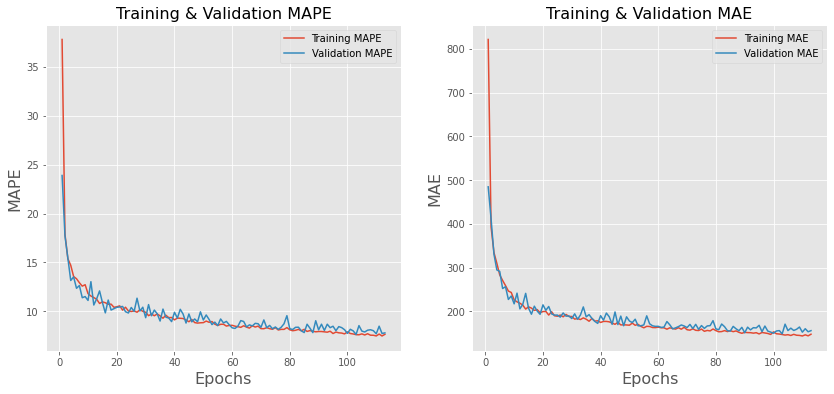

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']
    x = range(1, len(loss) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(x, loss, label='Training MAPE')
    ax[0].plot(x, val_loss, label='Validation MAPE')
    ax[0].set_title('Training & Validation MAPE', fontsize=16)
    ax[0].set_xlabel('Epochs', fontsize=16)
    ax[0].set_ylabel('MAPE', fontsize=16)
    ax[0].legend()
    #
    # Plot the loss vs Epochs
    #
    ax[1].plot(x, mae, label='Training MAE')
    ax[1].plot(x, val_mae,label='Validation MAE')
    ax[1].set_title('Training & Validation MAE', fontsize=16)
    ax[1].set_xlabel('Epochs', fontsize=16)
    ax[1].set_ylabel('MAE', fontsize=16)
    ax[1].legend()

    plt.show()

plot_history(history)

## Results

### Mean Average Percentage Error (MAPE)

In [ ]:
y_pred = model.predict(X_test)[:,0]
print("MAPE of trained model is ",MAPE(y_pred, y_test))

MAPE of trained model is  8.442787544177637


In [ ]:
MAPE(y_pred, y_test)

8.442787544177637

### MAE, MSE and RMSE

In [ ]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))


MAE: 127.79205964461616
MSE: 40556.27275531666
RMSE: 201.38588022827386
VarScore: 0.9802111255050062


### Visualizing Predictions

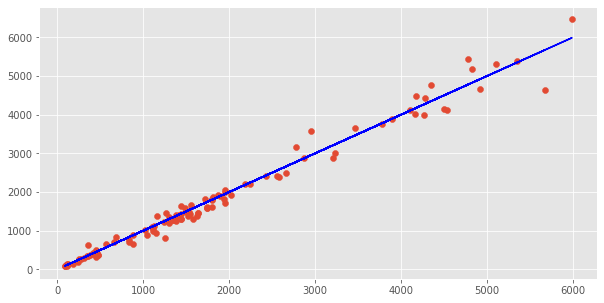

In [ ]:
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
# Perfect predictions
plt.plot(y_test,y_test,'b')

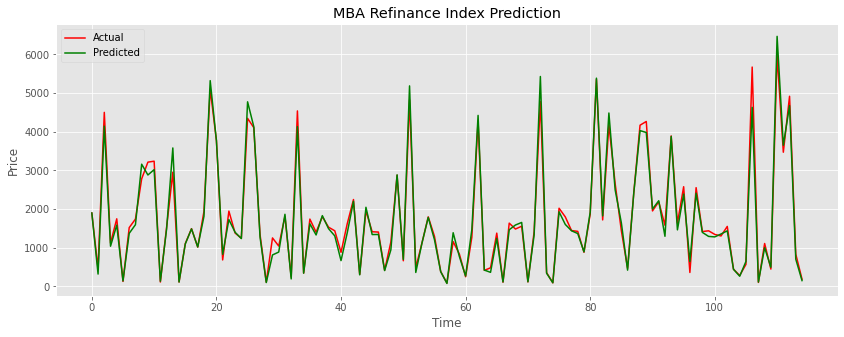

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Actual')
plt.plot(y_pred, color = 'green', label = 'Predicted')
plt.title('MBA Refinance Index Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
!jupyter nbconvert --to html "/content/gdrive/My Drive/Colab Notebooks/ANLY535/ANLY535 Final Project/Team3 Final Project.ipynb"

[NbConvertApp] Converting notebook /content/gdrive/My Drive/Colab Notebooks/ANLY535/ANLY535 Final Project/Team3 Final Project.ipynb to html
